# Vetorização
O objetivo desta etapa é transpor o texto da descrição da prestação de contas para um vetor numérico multidimensional. Realizaremos uma série de experimentos para definir os melhores hiperparâmetros.

In [1]:
import os
import pickle
import warnings   
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, DocumentRNNEmbeddings, Sentence

random_state = 133
sns.set(rc={'figure.figsize':(15,5)})
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_colwidth' , 100)

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('portuguese')

Carregar dataframe pre-processado:

In [18]:
df = pd.read_feather('df_preprocessado.feather').set_index('index')
print('dimensão do dataset:', df.shape)

dimensão do dataset: (5598785, 22)


## Preparação

Analisemos a quantidade de instâncias por classe:

In [20]:
df.tipo_despesa_code.value_counts()

29    1280255
31     673951
26     609725
9      553850
4      529345
2      446185
13     328760
3      252382
32     188863
11     157043
23     100744
24      80283
27      74194
20      66062
28      47688
0       38146
18      35291
5       30065
12      18673
19      17545
10      10994
17       9759
6        9620
15       6748
16       6198
25       5447
34       5256
7        4532
33       3356
14       3138
22       1732
1        1208
30        864
8         699
21        184
Name: tipo_despesa_code, dtype: int64

Vamos a seguir balancear o dataset que utilizaremos para definir os hiperparâmetros. O balanceamento é importante para darmos o mesmo peso para as diferentes classes.

In [20]:
g = df[['descricao_despesa', 'tipo_despesa_code']].groupby('tipo_despesa_code')

df_sample = g.apply(lambda x: x.sample(g.size().min(), random_state=random_state).reset_index(drop=True)).reset_index(drop=True)

Dimensão do dataset de experimentos:

In [17]:
df_sample.shape

(6440, 2)

Como ficaram a distribuição das instâncias por classe:

In [18]:
df_sample.tipo_despesa_code.value_counts()

31    184
32    184
21    184
17    184
13    184
9     184
5     184
1     184
28    184
29    184
24    184
20    184
16    184
12    184
8     184
4     184
25    184
33    184
27    184
34    184
23    184
19    184
15    184
11    184
7     184
3     184
30    184
2     184
26    184
22    184
18    184
14    184
10    184
6     184
0     184
Name: tipo_despesa_code, dtype: int64

## TF-IDF
Sigla para Term Frequency-Inverse Document Frequency é uma medida estatística utilizada para representação vetorial de palavras.


### Experimento
Faremos experimentos para encontrar os melhores hiperparâmetros para extração de features das descrições das prestações de conta.

Vamos separar o dataset para realizarmos o treinamento e teste. Porque treinamento e teste para a vetorização? Para avaliar a qualidade. Utilizaremos o classificador Naive Bayes para modelos multidimensionais, o MultinomialNB do SKLearn.

In [18]:
def train_test_split_balanced(X, y, random_state):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=random_state)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa.values,
                                                             df_sample.tipo_despesa_code.values,
                                                             random_state = random_state)

In [21]:
y, qtde = np.unique(y_train, return_counts=True)
for t in np.arange(len(y)):
    print (y[t], qtde[t])

0 157
1 156
2 156
3 156
4 157
5 157
6 156
7 157
8 156
9 157
10 157
11 156
12 156
13 156
14 156
15 157
16 157
17 157
18 156
19 157
20 156
21 156
22 156
23 157
24 156
25 157
26 156
27 157
28 156
29 156
30 156
31 157
32 156
33 156
34 156


### Baseline

In [25]:
pipe = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", MultinomialNB()),
    ]
)

In [26]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(pipe.score(X_test, y_test)))
print(cr)

Baseline TF-IDF categorization accuracy: 0.653
              precision    recall  f1-score   support

           0       0.61      0.63      0.62        27
           1       0.50      1.00      0.67        28
           2       0.65      0.46      0.54        28
           3       0.56      0.82      0.67        28
           4       1.00      0.81      0.90        27
           5       0.55      0.67      0.60        27
           6       0.96      0.89      0.93        28
           7       0.73      0.81      0.77        27
           8       0.64      0.32      0.43        28
           9       0.35      0.81      0.49        27
          10       0.70      0.70      0.70        27
          11       0.14      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.62      0.86      0.72        28
          14       0.84      0.93      0.88        28
          15       0.87      1.00      0.93        27
          16       0.31      0.19 

### Remover Pontuação

In [29]:
df_sample['descricao_despesa_semPont'] = df_sample.descricao_despesa.str.replace('[^\w\s]',' ')
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_semPont.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(pipe.score(X_test, y_test)))
print(cr)

Baseline TF-IDF categorization accuracy: 0.653
              precision    recall  f1-score   support

           0       0.61      0.63      0.62        27
           1       0.50      1.00      0.67        28
           2       0.65      0.46      0.54        28
           3       0.56      0.82      0.67        28
           4       1.00      0.81      0.90        27
           5       0.55      0.67      0.60        27
           6       0.96      0.89      0.93        28
           7       0.73      0.81      0.77        27
           8       0.64      0.32      0.43        28
           9       0.35      0.81      0.49        27
          10       0.70      0.70      0.70        27
          11       0.14      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.62      0.86      0.72        28
          14       0.84      0.93      0.88        28
          15       0.87      1.00      0.93        27
          16       0.31      0.19 

Não faz diferença.
### remover stopwords

In [30]:
df_sample['descricao_despesa_stop'] = df_sample['descricao_despesa'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_stop.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
X_train.shape

(5474,)

In [31]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(pipe.score(X_test, y_test)))
print(cr)

Baseline TF-IDF categorization accuracy: 0.653
              precision    recall  f1-score   support

           0       0.59      0.63      0.61        27
           1       0.50      1.00      0.67        28
           2       0.67      0.50      0.57        28
           3       0.55      0.82      0.66        28
           4       0.96      0.81      0.88        27
           5       0.51      0.67      0.58        27
           6       0.96      0.89      0.93        28
           7       0.79      0.81      0.80        27
           8       0.67      0.36      0.47        28
           9       0.36      0.78      0.49        27
          10       0.69      0.67      0.68        27
          11       0.20      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.62      0.86      0.72        28
          14       0.84      0.93      0.88        28
          15       0.90      1.00      0.95        27
          16       0.35      0.22 

Não faz diferença.

### Remover dígitos
Nesta etapa removeremos todos os números do corpus e verificar se houve melhora na vetorização.

In [34]:
df_sample['descricao_despesa_sdig'] = df_sample['descricao_despesa'].str.replace('\d+', '')
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_sdig.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(pipe.score(X_test, y_test)))
print(cr)

Baseline TF-IDF categorization accuracy: 0.661
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        27
           1       0.50      1.00      0.67        28
           2       0.62      0.46      0.53        28
           3       0.57      0.82      0.68        28
           4       0.96      0.85      0.90        27
           5       0.54      0.74      0.62        27
           6       0.96      0.89      0.93        28
           7       0.73      0.81      0.77        27
           8       0.69      0.32      0.44        28
           9       0.36      0.81      0.50        27
          10       0.72      0.78      0.75        27
          11       0.17      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.62      0.89      0.74        28
          14       0.84      0.93      0.88        28
          15       0.93      1.00      0.96        27
          16       0.38      0.22 

Removendo dígitos melhorou a acurácia.

### Remover Palavras Pequenas 
Removeremos nesta etapa palavras que tenham apenas 2 caracteres.

In [38]:
df_sample['descricao_despesa_sdig_n1'] = df_sample['descricao_despesa_sdig'].apply(lambda x: ' '.join(word for word in x.split() if len(word)>2))
#df_sample['descricao_despesa_stop_sdig'].head()
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_sdig_n1.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(pipe.score(X_test, y_test)))
print(cr)

Baseline TF-IDF categorization accuracy: 0.657
              precision    recall  f1-score   support

           0       0.51      0.67      0.58        27
           1       0.50      1.00      0.67        28
           2       0.70      0.50      0.58        28
           3       0.52      0.82      0.64        28
           4       0.96      0.81      0.88        27
           5       0.53      0.74      0.62        27
           6       0.96      0.93      0.95        28
           7       0.73      0.81      0.77        27
           8       0.60      0.32      0.42        28
           9       0.37      0.81      0.51        27
          10       0.71      0.74      0.73        27
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00        28
          13       0.62      0.89      0.74        28
          14       0.84      0.93      0.88        28
          15       0.87      1.00      0.93        27
          16       0.33      0.22 

Removendo pequenas palavras piorou a acurácia.

### Versão com descrição escolhida
Vamos trabalhar agora com a descrição das prestações utilizando as alterações que percebemos melhora na acurácia.

In [40]:
df_sample['descricao_despesa_tfidf_otimo'] = df_sample['descricao_despesa_sdig_n1']
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_tfidf_otimo.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
X_train.shape

(5474,)

### Escolha dos Melhores Hiperparâmetros
Vamos iniciar a escolha dos hiperparâmetros utilizando a mesma técnica anterior das pipelines:

In [43]:
param_grid = {
                'tfidf__max_features': np.arange(1,300, 1),
                'tfidf__analyzer': ['word', 'char', 'char_wb'],
                'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4),
                                       (2,2), (2,3), (2,4),
                                       (3,3), (3,4),
                                       (4,4)]
             }

pipe_cv = GridSearchCV(pipe,
                       param_grid=param_grid,
                       verbose=1,
                       n_jobs=(1 if os.name == 'nt' else -1),
                       cv=5)



pipe_cv.fit(X_train, y_train)
print('''
Best CV params: max_features={max_features},analyzer = {analyzer}, ngram_range = {ngram_range},
max_df = {max_df}, min_df = {min_df}
'''.format(**pipe_cv.best_estimator_.steps[0][1].get_params()))
print('Best TF-IDF categorization accuracy: {:.3f}'
      .format(pipe_cv.score(X_test, y_test)))


Fitting 5 folds for each of 8970 candidates, totalling 44850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |


Best CV params: max_features=299,analyzer = word, ngram_range = (1, 1),
max_df = 1.0, min_df = 1

Best TF-IDF categorization accuracy: 0.588


[Parallel(n_jobs=-1)]: Done 44850 out of 44850 | elapsed: 38.7min finished


In [44]:
y_pred = pipe_cv.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.17      0.74      0.27        27
           1       0.50      1.00      0.67        28
           2       0.52      0.39      0.45        28
           3       0.56      0.82      0.67        28
           4       1.00      0.81      0.90        27
           5       0.65      0.74      0.69        27
           6       0.95      0.71      0.82        28
           7       0.77      0.74      0.75        27
           8       0.50      0.14      0.22        28
           9       0.31      0.67      0.42        27
          10       0.53      0.59      0.56        27
          11       0.25      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.65      0.79      0.71        28
          14       0.87      0.93      0.90        28
          15       0.87      0.96      0.91        27
          16       0.64      0.26      0.37        27
          17       0.55    

O resultado não é satisfatório se considerarmos os resultados que tivemos anteriormente na baseline, ou seja, o TF-IDF com o valor padrão. Vamos abordar de outra forma, mais visual, atuando em cada hiperparâmetro por vez.

#### max_features

In [45]:
def analisar_hyper(X, Y, # A seguir são os valores padrões do próprio algoritmo
                    lista_max_features = None,
                    lista_analyzer = ['word'],
                    lista_ngram_range = [(1,1)],
                    lista_max_df = [1.0],
                    lista_min_df = [1]):
    resposta = {}
    df_respostas = pd.DataFrame()
    for t in lista_max_features:
        #print('max_features', t)
        for z in lista_analyzer:
            for w in lista_ngram_range:
                for y in lista_max_df:
                    for q in lista_min_df:
                        tfidf_vectorizer = TfidfVectorizer(max_features = t,
                                                           analyzer = z,
                                                           ngram_range = w,
                                                           max_df = y,
                                                           min_df = q
                                                          )
                        X_tf = tfidf_vectorizer.fit_transform(X)
                        X_train, X_test, y_train, y_test = train_test_split_balanced(X_tf.todense(),Y, random_state=random_state)

                        mnb = MultinomialNB().fit(X_train, y_train)
                        y_pred = mnb.predict(X_test)
                        acuracia = mnb.score(X_test, y_test)
                        resposta['max_features'] = t
                        resposta['analyzer'] = z
                        resposta['ngram_range'] = w
                        resposta['max_df'] = y
                        resposta['min_df'] = q
                        resposta['acuracia'] = acuracia

                        df_respostas = df_respostas.append(pd.DataFrame([resposta]), ignore_index = True)
        
    return df_respostas

In [48]:
df_respostas = analisar_hyper(X = df_sample.descricao_despesa_tfidf_otimo.values,
                      Y = df_sample.tipo_despesa_code.values,
                      lista_max_features = np.arange(1,4001, 1))

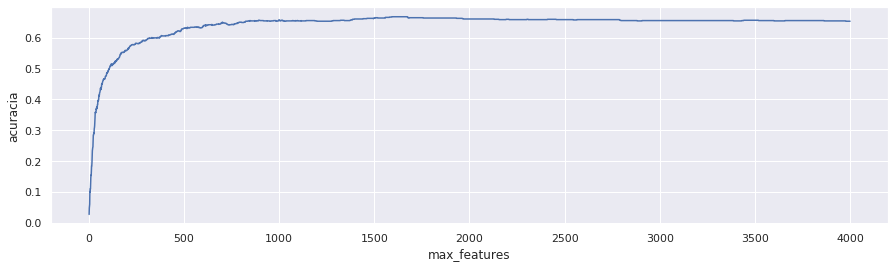

In [49]:
plt.figure(figsize=(15,4))
sns.lineplot(x = 'max_features', y =  'acuracia', data = df_respostas) #, ax=ax[0])

In [50]:
print('Máximo valor de acurácia:', df_respostas.acuracia.max())
print('Mínimo max_features com valor máximo de acurácia',
      df_respostas[df_respostas.acuracia == df_respostas.acuracia.max()].max_features.min() )


Máximo valor de acurácia: 0.6677018633540373
Mínimo max_features com valor máximo de acurácia 1592


#### analyzer e ngram_range

In [75]:
df_respostas = analisar_hyper(X = df_sample.descricao_despesa_tfidf_otimo.values,
                      Y = df_sample.tipo_despesa_code.values,
                      lista_max_features = np.arange(1502,1702, 10),
                      lista_analyzer = ['word', 'char', 'char_wb'],
                      lista_ngram_range = [(1,1), (1,2), (1,3), (1,4),
                                           (2,2), (2,3), (2,4),
                                           (3,3), (3,4),
                                           (4,4)])

<Figure size 1080x288 with 0 Axes>

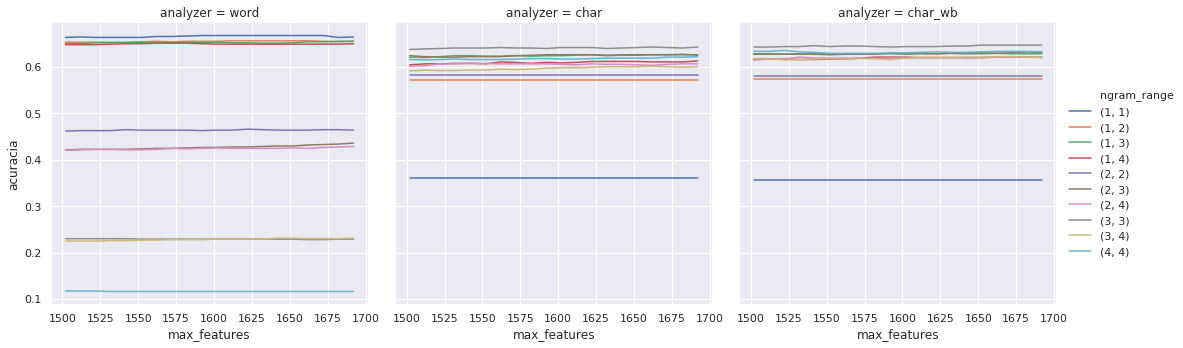

In [76]:
plt.figure(figsize=(15,4))
sns.relplot(x = 'max_features', y =  'acuracia',
            hue = 'ngram_range', col='analyzer',
            kind="line", data = df_respostas)

In [77]:
df_respostas[df_respostas.acuracia == df_respostas.acuracia.max()]

max_features analyzer ngram_range  max_df  min_df  acuracia
270          1592     word      (1, 1)     1.0       1  0.667702
300          1602     word      (1, 1)     1.0       1  0.667702
330          1612     word      (1, 1)     1.0       1  0.667702
360          1622     word      (1, 1)     1.0       1  0.667702
390          1632     word      (1, 1)     1.0       1  0.667702
420          1642     word      (1, 1)     1.0       1  0.667702
450          1652     word      (1, 1)     1.0       1  0.667702
480          1662     word      (1, 1)     1.0       1  0.667702
510          1672     word      (1, 1)     1.0       1  0.667702

In [78]:
df_respostas_word = analisar_hyper(X = df_sample.descricao_despesa_tfidf_otimo.values,
                      Y = df_sample.tipo_despesa_code.values,
                      lista_max_features = np.arange(202,1702, 10),
                      lista_analyzer = ['word'],
                      lista_ngram_range = [(1,1), (1,2), (1,3)])

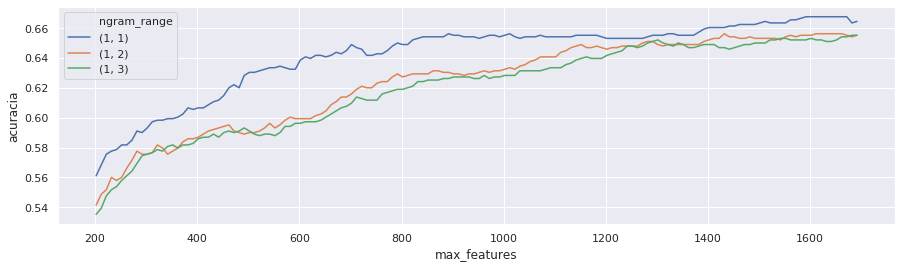

In [79]:
plt.figure(figsize=(15,4))
sns.lineplot(x = 'max_features', y =  'acuracia',
            hue = 'ngram_range', data = df_respostas_word)

In [80]:
df_respostas_word[df_respostas_word.acuracia == df_respostas_word.acuracia.max()]

max_features analyzer ngram_range  max_df  min_df  acuracia
417          1592     word      (1, 1)     1.0       1  0.667702
420          1602     word      (1, 1)     1.0       1  0.667702
423          1612     word      (1, 1)     1.0       1  0.667702
426          1622     word      (1, 1)     1.0       1  0.667702
429          1632     word      (1, 1)     1.0       1  0.667702
432          1642     word      (1, 1)     1.0       1  0.667702
435          1652     word      (1, 1)     1.0       1  0.667702
438          1662     word      (1, 1)     1.0       1  0.667702
441          1672     word      (1, 1)     1.0       1  0.667702

O analyzer __word__ com ngram_range igual a (1,1) obteve a melhor acurácia, sendo que este ngram_range é o valor normal.

#### max_df

In [81]:
df_respostas_max_df = analisar_hyper(X = df_sample.descricao_despesa_tfidf_otimo.values,
                      Y = df_sample.tipo_despesa_code.values,
                      lista_max_features = np.arange(992,1702, 100),
                      lista_analyzer = ['word'],
                      lista_max_df = np.linspace(0.1, 1.0,10))

In [82]:
df_respostas_max_df.max_df = df_respostas_max_df.max_df.astype(str).str.slice(stop=3)

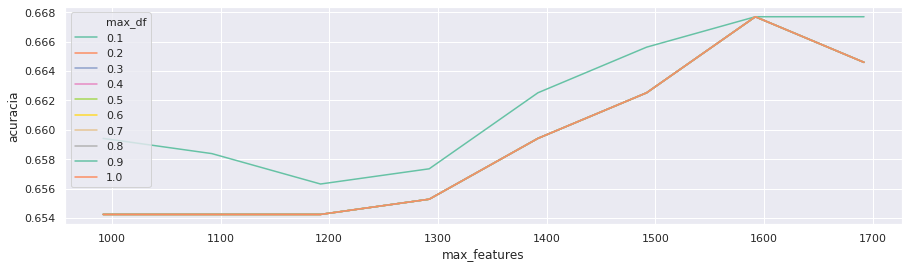

In [83]:
plt.figure(figsize=(15,4))
sns.lineplot(x = 'max_features', y =  'acuracia',
            hue = 'max_df', palette=sns.color_palette("Set2", 10),
            data = df_respostas_max_df)


In [84]:
df_respostas_max_df[df_respostas_max_df.acuracia == df_respostas_max_df.acuracia.max()]

max_features analyzer ngram_range max_df  min_df  acuracia
60          1592     word      (1, 1)    0.1       1  0.667702
61          1592     word      (1, 1)    0.2       1  0.667702
62          1592     word      (1, 1)    0.3       1  0.667702
63          1592     word      (1, 1)    0.4       1  0.667702
64          1592     word      (1, 1)    0.5       1  0.667702
65          1592     word      (1, 1)    0.6       1  0.667702
66          1592     word      (1, 1)    0.7       1  0.667702
67          1592     word      (1, 1)    0.8       1  0.667702
68          1592     word      (1, 1)    0.9       1  0.667702
69          1592     word      (1, 1)    1.0       1  0.667702
70          1692     word      (1, 1)    0.1       1  0.667702

In [85]:
df_respostas_max_df_2 = analisar_hyper(X = df_sample.descricao_despesa_tfidf_otimo.values,
                      Y = df_sample.tipo_despesa_code.values,
                      lista_max_features = np.arange(1500,1700, 1),
                      lista_analyzer = ['word'],
                      lista_max_df = [1.0])

In [86]:
df_respostas_max_df_2.max_df = df_respostas_max_df_2.max_df.astype(str).str.slice(stop=4)

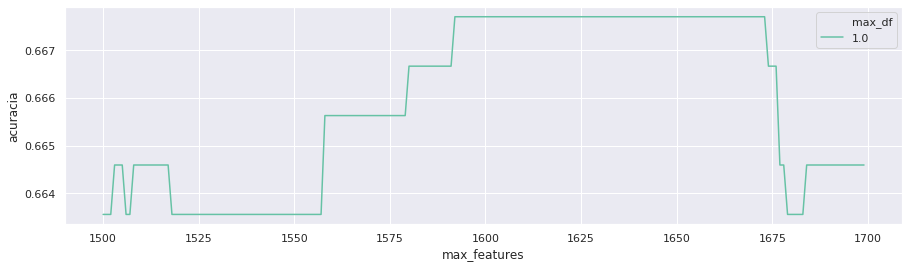

In [87]:
plt.figure(figsize=(15,4))
sns.lineplot(x = 'max_features', y =  'acuracia',
            hue = 'max_df', palette=sns.color_palette("Set2", 1),
            data = df_respostas_max_df_2)


#### Versão com melhores hiperparâmetros

Parâmetros escolhidos para o TF-IDF com acurácia de 0.668:
- max_features = __1592__;
- analyzer = __word__.

Não se obteve parâmetros ngram_range e max_df melhores que os valores padrões. 
### Versão com descrição escolhida
Vamos trabalhar agora com a descrição das prestações utilizando as alterações que percebemos melhora na acurácia. Primeiro vamos aplicar em todo dataset as otimizações do corpus com melhor resultado: 
- Remover dígitos;
- Remover palabras pequenas.

In [22]:
df['descricao_despesa_otimo_tfidf'] = df['descricao_despesa'].str.replace('\d+', '')
df['descricao_despesa_otimo_tfidf'] = df['descricao_despesa_otimo_tfidf'].apply(lambda x: ' '.join(word for word in x.split() if len(word)>2))

In [23]:
tfidf_matrix = TfidfVectorizer(max_features=1592,
                               analyzer = 'word'
                              ).fit_transform([x for x in df['descricao_despesa_otimo_tfidf']])
pickle.dump(tfidf_matrix, open("tfidf_matrix_bestNaive_maxFeat1592_analyzerWord.pickle", "wb"))

## Flair
Vamos utilizar nesta etapa uma outra abordagem de vetorização de texto, utilizando a biblioteca __flair__ [2].

In [24]:
glove_embedding = WordEmbeddings('pt')

In [26]:
def createMatrix(data_train, data_test, doc_embeddings):
    # Treino
    data_flair_matrix_train = []
    for x in data_train:
        sentence = Sentence(x)
        doc_embeddings.embed(sentence)
        data_flair_matrix_train.append(sentence.get_embedding().detach().numpy())
        
    data_flair_matrix_train = np.asarray([t for t in data_flair_matrix_train])
    
    #Teste
    data_flair_matrix_test = []
    for x in data_test:
        sentence = Sentence(x)
        doc_embeddings.embed(sentence)
        data_flair_matrix_test.append(sentence.get_embedding().detach().numpy())
        
    data_flair_matrix_test = np.asarray([t for t in data_flair_matrix_test])
    
    # Normalizar
    escalador = MinMaxScaler()
    data_flair_matrix_train = escalador.fit_transform(data_flair_matrix_train)
    data_flair_matrix_test = escalador.transform(data_flair_matrix_test)
    
    return data_flair_matrix_train, data_flair_matrix_test

In [22]:
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)

### DocumentPoolEmbeddings

In [25]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [27]:
X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)
mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.499

Baseline TF-IDF categorization accuracy: 0.513
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.36      1.00      0.53        28
           2       0.61      0.39      0.48        28
           3       0.44      0.75      0.55        28
           4       1.00      0.70      0.83        27
           5       0.30      0.67      0.41        27
           6       1.00      0.36      0.53        28
           7       0.66      0.78      0.71        27
           8       0.83      0.18      0.29        28
           9       0.21      0.44      0.29        27
          10       0.81      0.63      0.71        27
          11       0.10      0.07      0.08        28
          12       0.00      0.00      0.00        28
          13       0.57      0.43      0.49        28
          14       0.95      0.64      0.77        28
          15       0.93      0.48      0.63        27
          16       0.31      0.19 

#### Utilizando Forward e Backward Embeddings

In [28]:
flair_embedding_forward = FlairEmbeddings('pt-forward')
flair_embedding_backward = FlairEmbeddings('pt-backward')

In [29]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward])

In [30]:
X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)

In [31]:
mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.495

Baseline TF-IDF categorization accuracy: 0.487
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        27
           1       0.50      1.00      0.67        28
           2       0.50      0.43      0.46        28
           3       0.31      0.64      0.41        28
           4       1.00      0.70      0.83        27
           5       0.29      0.22      0.25        27
           6       0.93      0.50      0.65        28
           7       0.87      0.74      0.80        27
           8       0.50      0.14      0.22        28
           9       0.18      0.44      0.26        27
          10       0.46      0.48      0.47        27
          11       0.12      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.54      0.50      0.52        28
          14       0.85      0.79      0.81        28
          15       1.00      0.41      0.58        27
          16       0.22      0.07 

#### Max Pooling

In [32]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward],
                                            pooling='max')

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)
    
mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.487

Baseline TF-IDF categorization accuracy: 0.481
              precision    recall  f1-score   support

           0       0.26      0.74      0.38        27
           1       0.50      1.00      0.67        28
           2       0.59      0.36      0.44        28
           3       0.32      0.57      0.41        28
           4       0.70      0.70      0.70        27
           5       0.41      0.26      0.32        27
           6       0.94      0.54      0.68        28
           7       0.67      0.67      0.67        27
           8       0.18      0.29      0.22        28
           9       0.21      0.30      0.24        27
          10       0.67      0.44      0.53        27
          11       0.29      0.07      0.11        28
          12       0.00      0.00      0.00        28
          13       0.56      0.54      0.55        28
          14       0.85      0.79      0.81        28
          15       0.88      0.52      0.65        27
          16       0.28      0.26 

#### Min Pooling

In [33]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward],
                                            pooling='min')

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)

mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.467

Baseline TF-IDF categorization accuracy: 0.453
              precision    recall  f1-score   support

           0       0.23      0.56      0.33        27
           1       0.50      1.00      0.67        28
           2       0.90      0.32      0.47        28
           3       0.29      0.68      0.41        28
           4       0.95      0.70      0.81        27
           5       0.47      0.26      0.33        27
           6       0.93      0.50      0.65        28
           7       0.73      0.70      0.72        27
           8       0.30      0.21      0.25        28
           9       0.15      0.37      0.21        27
          10       0.65      0.48      0.55        27
          11       0.17      0.04      0.06        28
          12       0.00      0.00      0.00        28
          13       0.48      0.43      0.45        28
          14       0.85      0.79      0.81        28
          15       0.92      0.41      0.56        27
          16       0.17      0.07 

#### Non Linear

In [34]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode='nonlinear')

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #472

Baseline TF-IDF categorization accuracy: 0.463
              precision    recall  f1-score   support

           0       0.74      0.52      0.61        27
           1       0.37      1.00      0.54        28
           2       0.64      0.32      0.43        28
           3       0.47      0.68      0.56        28
           4       0.95      0.70      0.81        27
           5       0.14      0.59      0.23        27
           6       0.77      0.36      0.49        28
           7       0.65      0.74      0.69        27
           8       0.83      0.18      0.29        28
           9       0.27      0.48      0.34        27
          10       0.79      0.56      0.65        27
          11       0.17      0.11      0.13        28
          12       0.00      0.00      0.00        28
          13       0.50      0.39      0.44        28
          14       0.73      0.68      0.70        28
          15       0.80      0.44      0.57        27
          16       0.47      0.30 

#### None fine tune

In [35]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode='none')

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.499

Baseline TF-IDF categorization accuracy: 0.513
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.36      1.00      0.53        28
           2       0.61      0.39      0.48        28
           3       0.44      0.75      0.55        28
           4       1.00      0.70      0.83        27
           5       0.30      0.67      0.41        27
           6       1.00      0.36      0.53        28
           7       0.66      0.78      0.71        27
           8       0.83      0.18      0.29        28
           9       0.21      0.44      0.29        27
          10       0.81      0.63      0.71        27
          11       0.10      0.07      0.08        28
          12       0.00      0.00      0.00        28
          13       0.57      0.43      0.49        28
          14       0.95      0.64      0.77        28
          15       0.93      0.48      0.63        27
          16       0.31      0.19 

### DocumentRNNEmbeddings

In [37]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) 

Baseline TF-IDF categorization accuracy: 0.328
              precision    recall  f1-score   support

           0       0.38      0.33      0.35        27
           1       0.30      1.00      0.46        28
           2       0.43      0.21      0.29        28
           3       0.16      0.32      0.21        28
           4       0.86      0.70      0.78        27
           5       0.13      0.48      0.20        27
           6       0.69      0.32      0.44        28
           7       0.62      0.59      0.60        27
           8       0.57      0.14      0.23        28
           9       0.12      0.33      0.18        27
          10       0.83      0.56      0.67        27
          11       0.10      0.04      0.05        28
          12       0.00      0.00      0.00        28
          13       0.45      0.50      0.47        28
          14       0.56      0.54      0.55        28
          15       0.75      0.33      0.46        27
          16       0.25      0.15 

#### LSTM

In [38]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding], rnn_type='LSTM')

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) 

Baseline TF-IDF categorization accuracy: 0.327
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        27
           1       0.30      1.00      0.46        28
           2       0.78      0.25      0.38        28
           3       0.14      0.36      0.20        28
           4       0.90      0.70      0.79        27
           5       0.09      0.44      0.15        27
           6       0.71      0.36      0.48        28
           7       0.54      0.56      0.55        27
           8       0.50      0.11      0.18        28
           9       0.12      0.33      0.17        27
          10       0.52      0.56      0.54        27
          11       0.00      0.00      0.00        28
          12       0.00      0.00      0.00        28
          13       0.52      0.39      0.45        28
          14       0.44      0.54      0.48        28
          15       0.45      0.37      0.41        27
          16       0.24      0.15 

### Modo Flair escolhido
A melhor configuração que obtivemos ao rodar o Flair foi a versão do DocumentPoolEmbeddings com apenas o Wordembeddings. O que vamos fazer a seguir é verificar se podemos melhorar ainda mais o score trabalhando o texto de entrada.

In [39]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding])

#### Baseline
Utilizaremos a descrição das despesas sem as alterações feitas na etapa do TF-IDF:

In [40]:
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)
X_train.shape

(5474,)

In [41]:
X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.499

Baseline TF-IDF categorization accuracy: 0.513
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.36      1.00      0.53        28
           2       0.61      0.39      0.48        28
           3       0.44      0.75      0.55        28
           4       1.00      0.70      0.83        27
           5       0.30      0.67      0.41        27
           6       1.00      0.36      0.53        28
           7       0.66      0.78      0.71        27
           8       0.83      0.18      0.29        28
           9       0.21      0.44      0.29        27
          10       0.81      0.63      0.71        27
          11       0.10      0.07      0.08        28
          12       0.00      0.00      0.00        28
          13       0.57      0.43      0.49        28
          14       0.95      0.64      0.77        28
          15       0.93      0.48      0.63        27
          16       0.31      0.19 

#### Stemmer
A seguir temos um passo importante para a mineração de textos, iremos reduzir as palavras para sua haste principal, ou seja, o radical. Para isto são removidos os afixos morfológicos presentes na palavra.

In [43]:
df_sample['descricao_despesa_tok'] = df_sample.descricao_despesa.apply(nltk.word_tokenize)
df_sample['descricao_despesa_tok'] = df_sample['descricao_despesa_tok'].apply(lambda x: [stemmer.stem(y) for y in x])
df_sample['descricao_despesa_tok'] = df_sample['descricao_despesa_tok'].str.join(' ')
X_train, X_test, y_train, y_test = train_test_split_balanced(df_sample.descricao_despesa_tok.values,
                                                    df_sample.tipo_despesa_code.values,
                                                    random_state=random_state)

X_train_flair_matrix, X_test_flair_matrix = createMatrix(X_train, X_test, document_embeddings)


mnb = MultinomialNB().fit(X_train_flair_matrix, y_train)

y_pred = mnb.predict(X_test_flair_matrix)
cr = classification_report(y_test, y_pred)
print('Baseline TF-IDF categorization accuracy: {:.3f}'
      .format(mnb.score(X_test_flair_matrix, y_test)))
print(cr) #0.396

Baseline TF-IDF categorization accuracy: 0.411
              precision    recall  f1-score   support

           0       0.42      0.30      0.35        27
           1       0.50      1.00      0.67        28
           2       0.69      0.32      0.44        28
           3       0.45      0.68      0.54        28
           4       0.93      0.48      0.63        27
           5       0.22      0.22      0.22        27
           6       1.00      0.43      0.60        28
           7       0.79      0.56      0.65        27
           8       0.10      0.04      0.05        28
           9       0.20      0.41      0.27        27
          10       0.75      0.56      0.64        27
          11       0.23      0.11      0.15        28
          12       0.00      0.00      0.00        28
          13       0.56      0.50      0.53        28
          14       0.67      0.57      0.62        28
          15       0.64      0.33      0.44        27
          16       0.20      0.07 

O score piorou. Logo não aplicaremos estas alterações no corpus.

### Versão com descrição escolhida
Vamos trabalhar agora com a descrição das prestações que obteve melhor resultado:

In [19]:
flair_matrix = createMatrix(df['descricao_despesa'].values, document_embeddings)

In [24]:
pickle.dump(flair_matrix, open("flair_matrix_bestNaive_Wordembbedings.pickle", "wb"), protocol=4)

# Referências
- [1] Freediscovery. Acessado em 23/07/2020: http://freediscovery.io/doc/stable/python/examples/optimize_tfidf.html
- [2] Flair. Acessado em 23/07/2020: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_5_DOCUMENT_EMBEDDINGS.md